Test the correlation between activation values calculated by atemporal and temporal (spiking) methods 

In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [2]:
from phasor_jax.modules import *
from phasor_jax.utils import *
from phasor_jax.training import *

In [3]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key, 2)

In [4]:
n_samples = 1000
n_channels = 128
sample = jax.random.uniform(subkey, shape=(n_samples, n_channels)) 

# Model

In [23]:
"""
Create a simple dense layer for the test
"""
def mlp(x, 
           spiking: bool = False,
           repeats: int = 3,
           **kwargs):
    
    if spiking:
        x = phase_to_train(x, repeats=repeats)
    
    x1 = conv_1d(n_channels)(x, spiking=spiking, **kwargs)
     
    return x1

In [24]:
#declare the model as a transformation
model = hk.transform(mlp)

In [25]:
#split the key and use it to create the model's initial parameters
key, subkey = jrnd.split(key)

#create two sets of parameters - with and without bias - to test the network
params = model.init(subkey, sample)
params2 = model.init(subkey, sample)

/Users/wilkie/anaconda3/envs/jax/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [26]:
#set the bias values on the first set of parameters to zero
params['phasor_dense']['bz'] = jnp.zeros_like(params['phasor_dense']['bz'])
#params['phasor_dense_1']['bz'] = jnp.zeros_like(params['phasor_dense_1']['bz'])

(array([ 218.,  310.,  438.,  540.,  688.,  827.,  989., 1127., 1178.,
        1287., 1265., 1283., 1182., 1119.,  962.,  858.,  669.,  515.,
         404.,  307.,  218.]),
 array([-0.20073946, -0.18162237, -0.16250528, -0.14338818, -0.12427109,
        -0.10515401, -0.08603691, -0.06691983, -0.04780273, -0.02868564,
        -0.00956855,  0.00954854,  0.02866563,  0.04778272,  0.06689981,
         0.0860169 ,  0.105134  ,  0.12425108,  0.14336817,  0.16248527,
         0.18160236,  0.20071945]),
 <BarContainer object of 21 artists>)

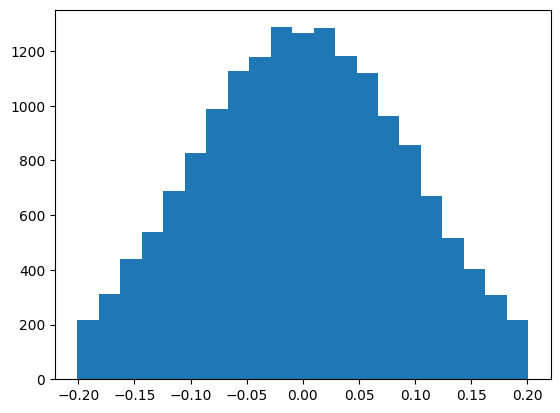

In [57]:
plt.hist(params['phasor_dense']['w'].ravel(), bins=21)

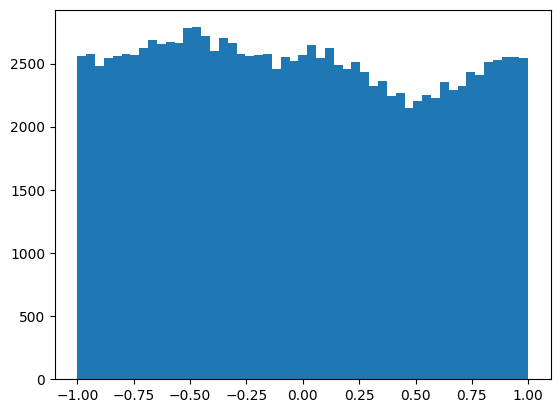

In [27]:
#without a bias value, the activations produced by a phasor neuron are uniformly distributed
l1 = model.apply(params, key, sample, spiking=False)

plt.hist(l1.ravel(), bins=51);

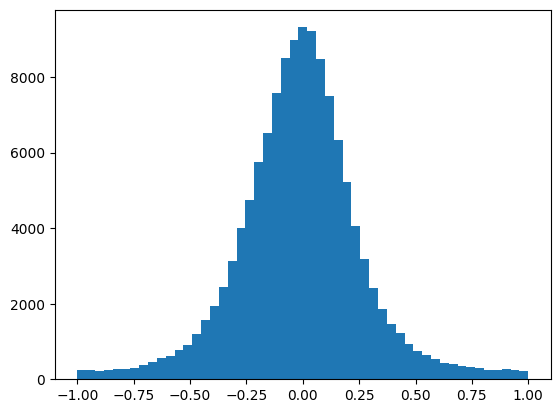

In [28]:
#with bias values, the activations become normally distributed around zero
bl1 = model.apply(params2, key, sample, spiking=False)

plt.hist(bl1.ravel(), bins=51);

In [29]:
#now, execute the model running in a temporal (spiking) manner
s1 = model.apply(params, key, sample, spiking=True, repeats=10, mask_angle=-1.0)

In [30]:
#calculate the phases represented by the spike trains
sp1 = train_to_phase(s1)

In [31]:
#calculate the spiking rates of each train for inspection (relative to firing once each cycle)
spiking_rate(s1)

0.79867734375

In [32]:
cycle_corr = [pearsonr(l1.ravel(), sp1[...,i].ravel()).statistic for i in range(sp1.shape[-1]-1)]

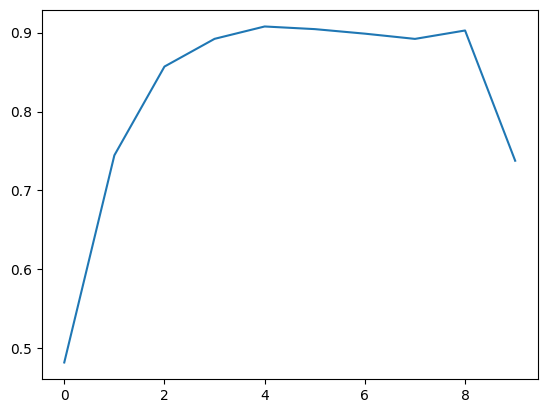

In [33]:
plt.plot(cycle_corr)

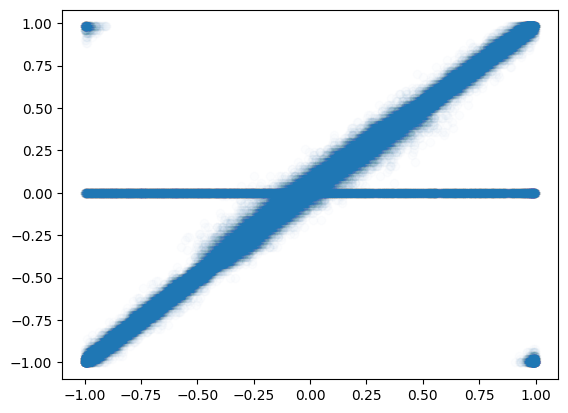

In [34]:
plt.scatter(l1.ravel(), sp1[...,4].ravel(), alpha=0.01)

In [36]:
bs1 = model.apply(params2, key, sample, spiking=True, repeats=10, mask_angle=-1.0)

In [37]:
st = phase_to_train(sample)

In [38]:
bsp1 = train_to_phase(bs1)

In [40]:
bias_cycle_corr = [pearsonr(bl1.ravel(), bsp1[...,i].ravel()).statistic for i in range(bsp1.shape[-1]-1)]

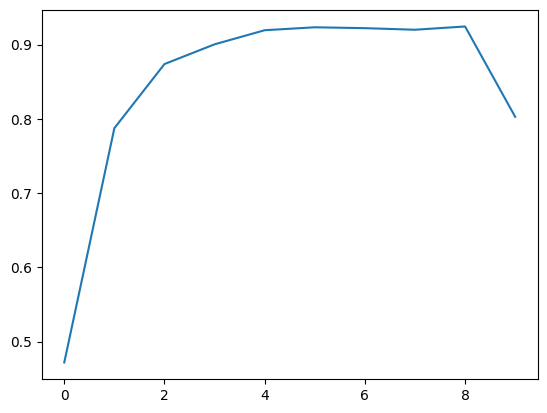

In [41]:
plt.plot(bias_cycle_corr)

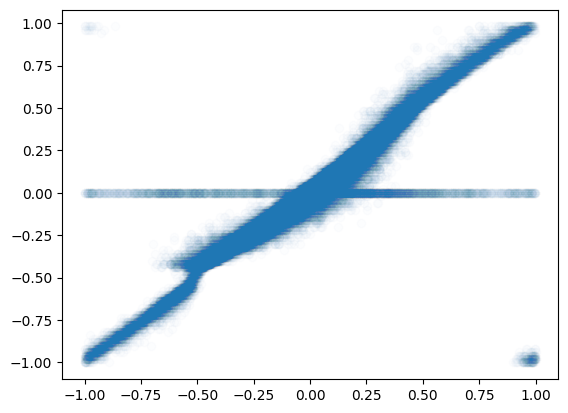

In [42]:
plt.scatter(bl1.ravel(), bsp1[...,4].ravel(), alpha=0.01)

In [43]:
def select_sample(st: SpikeTrain, i: int):
    n_neurons = st.full_shape[1]
    start_i = n_neurons * i
    stop_i = n_neurons * (i + 1)
    inds = (st.indices[0] >= start_i) * (st.indices[0] < stop_i)

    st_new = SpikeTrain([st.indices[0][inds] % n_neurons], st.times[inds], (1, st.full_shape[1]), st.offset)
    return st_new

In [44]:
def cut_time(st: SpikeTrain, t: float):
    inds = (st.times < t)

    st_new = SpikeTrain([st.indices[0][inds]], st.times[inds], st.full_shape[1], st.offset)
    return st_new

In [45]:
s1_i1 = cut_time(select_sample(s1, 0), 5.0)

In [46]:
bs1_i1 = cut_time(select_sample(bs1, 0), 5.0)

In [47]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [48]:
# Initialize figure with subplots
fig = make_subplots(
    rows=1, cols=2, subplot_titles=("No Bias", "Bias")
)

# Add traces
fig.add_trace(go.Scatter(x=s1_i1.indices[0], y=s1_i1.times, mode="markers"), row=1, col=1)
fig.add_trace(go.Scatter(x=bs1_i1.indices[0], y=bs1_i1.times, mode="markers"), row=1, col=2)

# Update xaxis properties
fig.update_xaxes(title_text="Neuron Index", row=1, col=1)
fig.update_xaxes(title_text="Neuron Index", row=1, col=2)
fig.update_yaxes(title_text="Time", row=1, col=1)
fig.update_yaxes(title_text="Time", row=1, col=2)

fig.update_layout(title_text="Firing Patterns from Random Weights and Inputs", height=500, width=1000,
                  font=dict({"size" : 16}))

In [49]:
import plotly.express as px

In [50]:
px.scatter(x=s1_i1.indices[0], y=s1_i1.times)

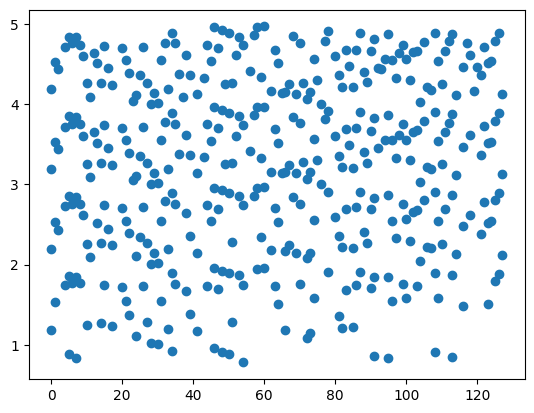

In [51]:
plt.scatter(s1_i1.indices[0], s1_i1.times)

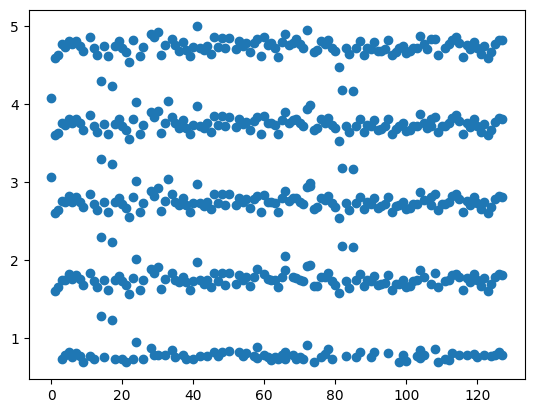

In [52]:
plt.scatter(bs1_i1.indices[0], bs1_i1.times)

In [53]:
s1

SpikeTrain(indices=[array([     0,      0,      0, ..., 127999, 127999, 127999])], times=array([1.19, 2.19, 3.19, ..., 7.04, 8.04, 9.04]), full_shape=(1000, 128), offset=0.25)

In [22]:
spiking_rate(bs2)

0.8328796875

In [23]:
b_corr1 = [pearsonr(bl1.ravel(), bsp1[...,i].ravel()).statistic for i in range(bsp1.shape[-1]-1)]
b_corr2 = [pearsonr(bl2.ravel(), bsp2[...,i].ravel()).statistic for i in range(bsp2.shape[-1]-1)]

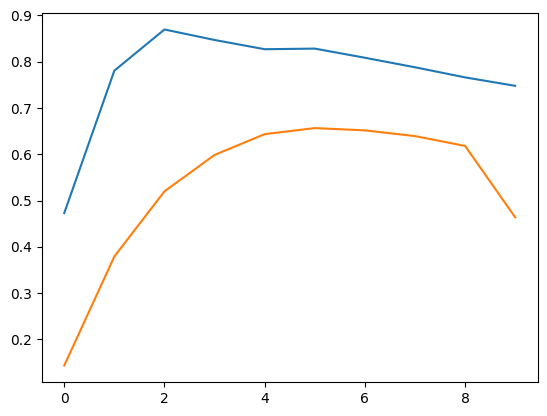

In [24]:
plt.plot(b_corr1)
plt.plot(b_corr2)

In [25]:
bs1.offset

0.25

In [26]:
bs2.offset

0.5

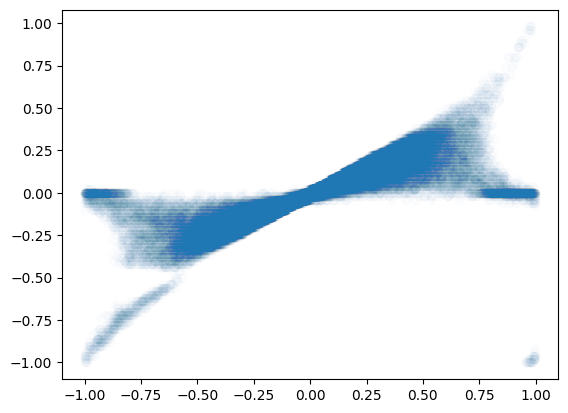

In [27]:
plt.scatter(bl1.ravel(), bsp1[...,4].ravel(), alpha=0.01)

In [28]:
spiking_rate(bs1)

0.9564953125

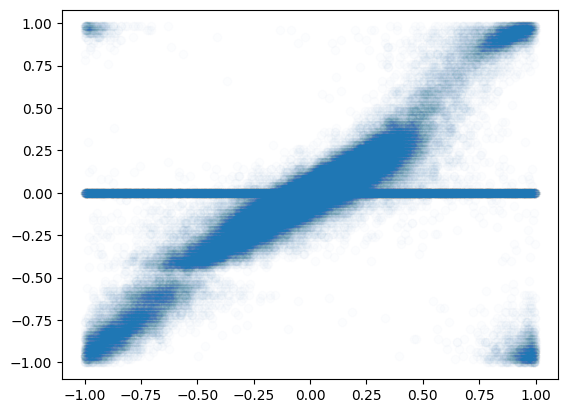

In [29]:
plt.scatter(bl2.ravel(), bsp2[...,4].ravel(), alpha=0.01)

In [30]:
spiking_rate(bs2)

0.8328796875

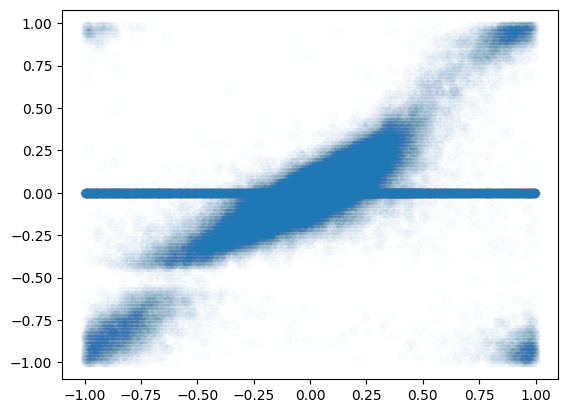

In [31]:
plt.scatter(bl2.ravel(), bsp2[...,2].ravel(), alpha=0.01)

In [34]:
mbs1, mbs2 = model.apply(params2, key, sample, spiking=True, mask_angle=0.1)

In [35]:
print(spiking_rate(mbs1))
print(spiking_rate(mbs2))

0.27306171875
0.2339984375


In [37]:
mbsp1 = train_to_phase(mbs1)
mbsp2 = train_to_phase(mbs2)

In [39]:
mb_corr1 = [pearsonr(bl1.ravel(), mbsp1[...,i].ravel()).statistic for i in range(mbsp1.shape[-1]-1)]
mb_corr2 = [pearsonr(bl2.ravel(), mbsp2[...,i].ravel()).statistic for i in range(mbsp2.shape[-1]-1)]

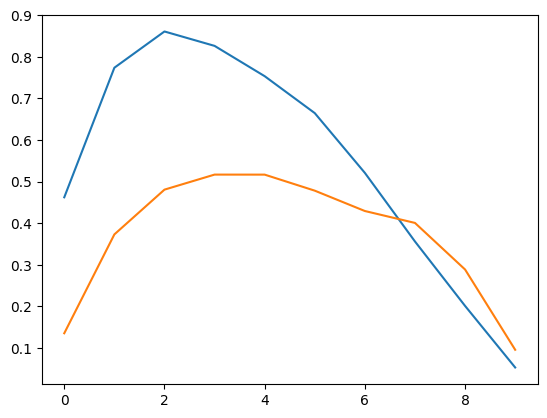

In [40]:
plt.plot(mb_corr1)
plt.plot(mb_corr2)

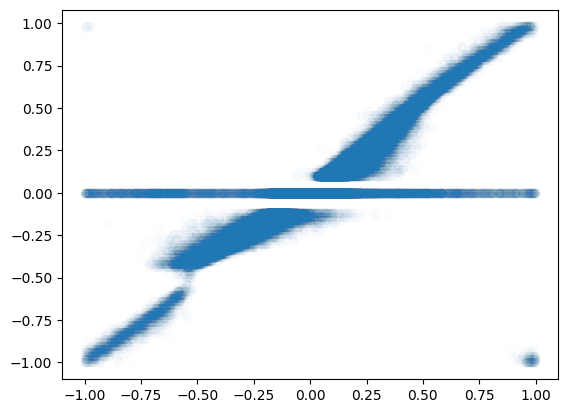

In [42]:
plt.scatter(bl1.ravel(), mbsp1[...,2].ravel(), alpha=0.01)

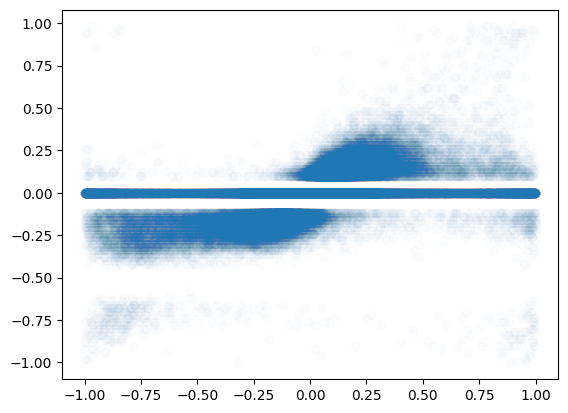

In [41]:
plt.scatter(bl2.ravel(), mbsp2[...,2].ravel(), alpha=0.01)

In [ ]:
spiking_rate(bs2)

0.8328796875

In [ ]:
b_corr1 = [pearsonr(bl1.ravel(), bsp1[...,i].ravel()).statistic for i in range(bsp1.shape[-1]-1)]
b_corr2 = [pearsonr(bl2.ravel(), bsp2[...,i].ravel()).statistic for i in range(bsp2.shape[-1]-1)]